# JMAN Churn model Evaluations

In [7]:
import platform
from datetime import date

import dtale
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyodbc
import scipy.stats
import seaborn as sns
import sweetviz
from scipy.interpolate import UnivariateSpline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sqlalchemy import create_engine, text
from sqlalchemy.engine import URL

# import pandas_profiling


pd.set_option("display.max_columns", None)

In [8]:
import os

# Change the current working directory
os.chdir(
    "C:/Users/DeepankarSrigyan/OneDrive - Sykes Cottages Ltd/Desktop/Project/JMAN CHURN/Analysis/"
)

In [11]:
def fetch_SQLserver_data(sql_code, conn_string):
    """
    Uses pyodbc.connect and pandas.read_sql to return query results as dataframe.
    :param sql_code: string, query to be submitted
    :param conn_string: string, full connection details as string
    """
    connection_url = URL.create("mssql+pyodbc", query={"odbc_connect": conn_string})
    engine = create_engine(connection_url)
    with engine.connect() as conn:
        df = pd.read_sql(sql=text(sql_code), con=conn)
        conn.commit()
    print("Data Imported")
    return df


if platform.system() == "Windows":
    conn_CDM = "DRIVER={ODBC Driver 17 for SQL Server};SERVER=BI-DATA-PROD-04;DATABASE=CDM;trusted_connection=Yes"
    conn_l0 = "DRIVER={ODBC Driver 17 for SQL Server};SERVER=BI-DATA-PROD-04;DATABASE=Sykes_DW_Level0_Staging;trusted_connection=Yes"
    conn_l2 = "DRIVER={ODBC Driver 17 for SQL Server};SERVER=BI-DATA-PROD-04;DATABASE=Sykes_DW_Level2_ADM;trusted_connection=Yes"
    conn_BOX = "DRIVER={ODBC Driver 17 for SQL Server};SERVER=BI-DATA-PROD-04;DATABASE=Box;trusted_connection=Yes"

    print("Connection Completed")

Connection Completed


## Taking data from SQL

In [13]:
Churn = fetch_SQLserver_data(
"""

SELECT CI.PropertyID
    , CI.PropertyReference
    -- ,CI.Year1Month
    , P.PropertyLiveDate
    -- , P.AvailableFromDate
    -- , P.AvailableToDate
    , P.DateToldWithdrawingLocal
    ,datediff(month,p.PropertyLiveDate,DateToldWithdrawingLocal)+1 as churned_month
    ,datediff(MONTH, P.PropertyLiveDate, getdate()) + 1 AS current_month
    ,case when datediff(day,p.PropertyLiveDate,DateToldWithdrawingLocal)<=365  then 1 else 0 end as churnflag
    ,max(ChurnProbability) as churn_probability
    ,RAND() AS prob_1
    ,RAND() AS prob_2
    ,RAND() AS prob_3
    ,RAND() AS prob_4
   
FROM JMAN.airflow.FACT_ChurnInformation CI
LEFT JOIN cdm.propertymanagement.Property P
    ON CI.PropertyID = P.PropertyID
-- where ci.PropertyReference=1113522
group by 
CI.PropertyID
    , CI
.PropertyReference
    -- ,CI.Year1Month
    , P.PropertyLiveDate
    , P.AvailableFromDate
    , P.AvailableToDate
    , P.DateToldWithdrawingLocal
    ,datediff(MONTH, P.PropertyLiveDate, getdate()) + 1
    ,datediff(month,p.PropertyLiveDate,DateToldWithdrawingLocal)
    ,case when
    datediff(day,p.PropertyLiveDate,DateToldWithdrawingLocal)<=365  then 1 else 0 end
    ORDER BY PropertyID
    -- , Year1Month


""",
    conn_CDM,
)
Churn

Data Imported


,PropertyID,PropertyReference,PropertyLiveDate,DateToldWithdrawingLocal,churned_month,current_month,churnflag,churn_probability,prob_1,prob_2,prob_3,prob_4
0,48593,906801,2023-12-06,None,NaN,7,0,0.114582,0.835754,0.648944,0.528409,0.714855
1,49237,24558,2024-03-14,None,NaN,4,0,0.148091,0.835754,0.648944,0.528409,0.714855
2,51456,3888,2024-03-19,None,NaN,4,0,0.141494,0.835754,0.648944,0.528409,0.714855
3,53749,14431,2023-11-28,None,NaN,8,0,0.167604,0.835754,0.648944,0.528409,0.714855
4,53802,15299,2023-07-03,None,NaN,12,0,0.118841,0.835754,0.648944,0.528409,0.714855
...,...,...,...,...,...,...,...,...,...,...,...,...
2425,272675,912340,2023-11-15,None,NaN,8,0,0.082998,0.835754,0.648944,0.528409,0.714855
2426,272696,1147380,2023-12-01,None,NaN,7,0,0.191337,0.835754,0.648944,0.528409,0.714855
2427,272938,1147497,2023-11-27,None,NaN,8,0,0.037043,0.835754,0.648944,0.528409,0.714855
2428,273167,1147750,2023-12-01,None,NaN,7,0,0.125106,0.835754,0.648944,0.528409,0.714855


## Object to date

In [14]:
def convert_date_column(df, column_name):
    """
    Converts a date column in a DataFrame from string (object) to datetime.

    Args:
    df (pd.DataFrame): The DataFrame containing the date column.
    column_name (str): The name of the column to convert.

    Returns:
    pd.DataFrame: A DataFrame with the date column converted to datetime.
    """
    df[column_name] = pd.to_datetime(df[column_name], format='%Y-%m-%d')
    return df

In [15]:
Churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2430 entries, 0 to 2429
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   PropertyID                2430 non-null   int64  
 1   PropertyReference         2430 non-null   object 
 2   PropertyLiveDate          2430 non-null   object 
 3   DateToldWithdrawingLocal  433 non-null    object 
 4   churned_month             433 non-null    float64
 5   current_month             2430 non-null   int64  
 6   churnflag                 2430 non-null   int64  
 7   churn_probability         2430 non-null   float64
 8   prob_1                    2430 non-null   float64
 9   prob_2                    2430 non-null   float64
 10  prob_3                    2430 non-null   float64
 11  prob_4                    2430 non-null   float64
dtypes: float64(6), int64(3), object(3)
memory usage: 227.9+ KB


In [16]:
convert_date_column(Churn,'PropertyLiveDate')

,PropertyID,PropertyReference,PropertyLiveDate,DateToldWithdrawingLocal,churned_month,current_month,churnflag,churn_probability,prob_1,prob_2,prob_3,prob_4
0,48593,906801,2023-12-06,None,NaN,7,0,0.114582,0.835754,0.648944,0.528409,0.714855
1,49237,24558,2024-03-14,None,NaN,4,0,0.148091,0.835754,0.648944,0.528409,0.714855
2,51456,3888,2024-03-19,None,NaN,4,0,0.141494,0.835754,0.648944,0.528409,0.714855
3,53749,14431,2023-11-28,None,NaN,8,0,0.167604,0.835754,0.648944,0.528409,0.714855
4,53802,15299,2023-07-03,None,NaN,12,0,0.118841,0.835754,0.648944,0.528409,0.714855
...,...,...,...,...,...,...,...,...,...,...,...,...
2425,272675,912340,2023-11-15,None,NaN,8,0,0.082998,0.835754,0.648944,0.528409,0.714855
2426,272696,1147380,2023-12-01,None,NaN,7,0,0.191337,0.835754,0.648944,0.528409,0.714855
2427,272938,1147497,2023-11-27,None,NaN,8,0,0.037043,0.835754,0.648944,0.528409,0.714855
2428,273167,1147750,2023-12-01,None,NaN,7,0,0.125106,0.835754,0.648944,0.528409,0.714855


## Jun2023 data where one year is almost compelted

In [17]:
Jun2023 = Churn[(Churn['PropertyLiveDate'] >= '2023-06-01') & (Churn['PropertyLiveDate'] < '2023-07-01')]
Jun2023

,PropertyID,PropertyReference,PropertyLiveDate,DateToldWithdrawingLocal,churned_month,current_month,churnflag,churn_probability,prob_1,prob_2,prob_3,prob_4
47,135194,1062290,2023-06-23,None,NaN,13,0,4.906204e-02,0.835754,0.648944,0.528409,0.714855
51,140303,1064689,2023-06-28,None,NaN,13,0,3.600027e-02,0.835754,0.648944,0.528409,0.714855
53,141928,1065785,2023-06-13,None,NaN,13,0,3.666933e-05,0.835754,0.648944,0.528409,0.714855
55,142598,1066479,2023-06-01,None,NaN,13,0,3.975603e-02,0.835754,0.648944,0.528409,0.714855
57,142830,1066706,2023-06-30,None,NaN,13,0,4.224382e-02,0.835754,0.648944,0.528409,0.714855
...,...,...,...,...,...,...,...,...,...,...,...,...
1564,234427,1137856,2023-06-30,None,NaN,13,0,4.601768e-02,0.835754,0.648944,0.528409,0.714855
1569,234507,1137998,2023-06-29,None,NaN,13,0,1.448923e-01,0.835754,0.648944,0.528409,0.714855
1574,234542,1138029,2023-06-29,2024-04-18,11.0,13,1,1.258370e-01,0.835754,0.648944,0.528409,0.714855
1599,234796,1138205,2023-06-30,2024-01-16,8.0,13,1,1.328340e-01,0.835754,0.648944,0.528409,0.714855


## Whole data

In [18]:
Churn

,PropertyID,PropertyReference,PropertyLiveDate,DateToldWithdrawingLocal,churned_month,current_month,churnflag,churn_probability,prob_1,prob_2,prob_3,prob_4
0,48593,906801,2023-12-06,None,NaN,7,0,0.114582,0.835754,0.648944,0.528409,0.714855
1,49237,24558,2024-03-14,None,NaN,4,0,0.148091,0.835754,0.648944,0.528409,0.714855
2,51456,3888,2024-03-19,None,NaN,4,0,0.141494,0.835754,0.648944,0.528409,0.714855
3,53749,14431,2023-11-28,None,NaN,8,0,0.167604,0.835754,0.648944,0.528409,0.714855
4,53802,15299,2023-07-03,None,NaN,12,0,0.118841,0.835754,0.648944,0.528409,0.714855
...,...,...,...,...,...,...,...,...,...,...,...,...
2425,272675,912340,2023-11-15,None,NaN,8,0,0.082998,0.835754,0.648944,0.528409,0.714855
2426,272696,1147380,2023-12-01,None,NaN,7,0,0.191337,0.835754,0.648944,0.528409,0.714855
2427,272938,1147497,2023-11-27,None,NaN,8,0,0.037043,0.835754,0.648944,0.528409,0.714855
2428,273167,1147750,2023-12-01,None,NaN,7,0,0.125106,0.835754,0.648944,0.528409,0.714855


## Precision and Recall

Precision:
Precision measures the accuracy of positive predictions. It answers the question: "Of all the items the model labeled as positive, what proportion were actually positive?"
Precision = True Positives / (True Positives + False Positives)

Recall:
Recall measures the model's ability to find all positive instances. It answers the question: "Of all the actual positive items, what proportion did the model correctly identify?"
Recall = True Positives / (True Positives + False Negatives)

## ROC Curve and AUC

## Gain and Lift Charts

In [19]:
def confusion_chart(data, threshold, churn_probability):
    import pandas as pd
    from sklearn.metrics import precision_score, recall_score, confusion_matrix, roc_curve, auc, precision_recall_curve,f1_score
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np

    # Calculate predicted churn based on the given threshold
    data['predicted_churn'] = (data[churn_probability] >= threshold).astype(int)
    
    # Calculate precision and recall
    precision = precision_score(data['churnflag'], data['predicted_churn'])
    recall = recall_score(data['churnflag'], data['predicted_churn'])
    f1 = f1_score(data['churnflag'], data['predicted_churn'])
    
    print(f'Precision: {precision:.2%}')
    print(f'Recall: {recall:.2%}')
    print(f'F1 Score: {f1:.2%}')
    
    # Calculate confusion matrix
    cm = confusion_matrix(data['churnflag'], data['predicted_churn'])
    tn, fp, fn, tp = cm.ravel()
    
    # Display confusion matrix values
    print("\nConfusion Matrix:")
    print(f"True Negatives: {tn}")
    print(f"False Positives: {fp}")
    print(f"False Negatives: {fn}")
    print(f"True Positives: {tp}")
    
    # Create confusion matrix heatmap with custom annotations
    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
    
    # Add custom text annotations for TP, FP, TN, FN
    labels = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
    counts = [tn, fp, fn, tp]
    percentages = cm / cm.sum() * 100
    label_counts = [f'{label}\n{count}\n({percent:.2f}%)' for label, count, percent in zip(labels, counts, percentages.flatten())]
    
    for (j, i), label in np.ndenumerate(cm):
        ax.text(i + 0.5, j + 0.5, label_counts[j * 2 + i], ha='center', va='center', color='black')
    
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # Create bar chart to show predicted vs actual
    metrics = ['True Positives', 'False Positives', 'True Negatives', 'False Negatives']
    values = [tp, fp, tn, fn]
    
    plt.figure(figsize=(8, 6))
    plt.bar(metrics, values, color=['green', 'red', 'blue', 'orange'])
    plt.title('Predicted vs Actual Cases')
    plt.xlabel('Metrics')
    plt.ylabel('Number of Cases')
    plt.show()

    # Calculate ROC curve and AUC
    fpr, tpr, _ = roc_curve(data['churnflag'], data[churn_probability])
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    # Calculate Precision-Recall curve
    precision_vals, recall_vals, _ = precision_recall_curve(data['churnflag'], data[churn_probability])
    pr_auc = auc(recall_vals, precision_vals)
    
    # Plot Precision-Recall curve
    plt.figure(figsize=(8, 6))
    plt.plot(recall_vals, precision_vals, color='blue', lw=2, label=f'Precision-Recall curve (area = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.show()
    
    # Calculate Gain and Lift chart
    data_sorted = data.sort_values(by=churn_probability, ascending=False)
    data_sorted['cumulative_churns'] = data_sorted['churnflag'].cumsum()
    data_sorted['cumulative_data'] = np.arange(1, len(data_sorted) + 1)
    data_sorted['gain'] = data_sorted['cumulative_churns'] / data_sorted['churnflag'].sum()
    data_sorted['lift'] = data_sorted['gain'] / (data_sorted['cumulative_data'] / len(data_sorted))
    
    # Plot Gain chart
    plt.figure(figsize=(8, 6))
    plt.plot(data_sorted['cumulative_data'] / len(data_sorted), data_sorted['gain'], color='green', lw=2, label='Gain')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random classifier')
    plt.xlabel('Cumulative % of Data')
    plt.ylabel('Cumulative % of Churns')
    plt.title('Gain Chart')
    plt.legend(loc="lower right")
    plt.show()
    
    # Plot Lift chart
    plt.figure(figsize=(8, 6))
    plt.plot(data_sorted['cumulative_data'] / len(data_sorted), data_sorted['lift'], color='purple', lw=2, label='Lift')
    plt.xlabel('Cumulative % of Data')
    plt.ylabel('Lift')
    plt.title('Lift Chart')
    plt.legend(loc="upper right")
    plt.show()
 
    
    # Display table of metrics
    metrics_data = {
        "Metric": ["Precision", "Recall", "ROC AUC", "PR AUC"],
        "Value": [precision, recall, roc_auc, pr_auc]
    }
    metrics_df = pd.DataFrame(metrics_data)
    print("\nMetrics Table:")
    print(metrics_df)

# Example usage:
# Assuming 'data' is your DataFrame with columns 'churnflag' and 'churn_probability'
# confusion_chart(data, 0.21, 'churn_probability')


TP (True Positive): The prediction was positive, and it was correct.

TN (True Negative): The prediction was negative, and it was correct.

FP (False Positive): The prediction was positive, but it was incorrect.
Also known as a "Type I error" or "false alarm".

FN (False Negative): The prediction was negative, but it was incorrect.
Also known as a "Type II error" or "miss".

Precision:
Precision measures the accuracy of positive predictions. It answers the question: "Of all the items the model labeled as positive, what proportion were actually positive?"
Precision = True Positives / (True Positives + False Positives)

Recall:
Recall measures the model's ability to find all positive instances. It answers the question: "Of all the actual positive items, what proportion did the model correctly identify?"
Recall = True Positives / (True Positives + False Negatives)

Precision: 20.82%
Recall: 14.32%
F1 Score: 16.97%

Confusion Matrix:
True Negatives: 1772
False Positives: 232
False Negatives: 365
True Positives: 61


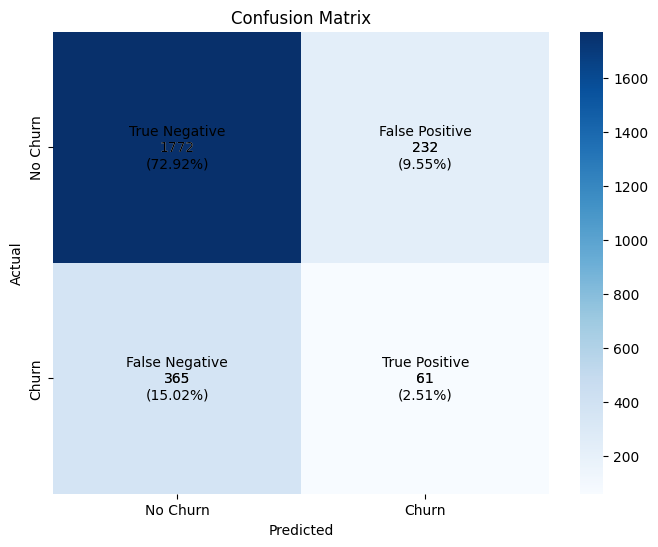

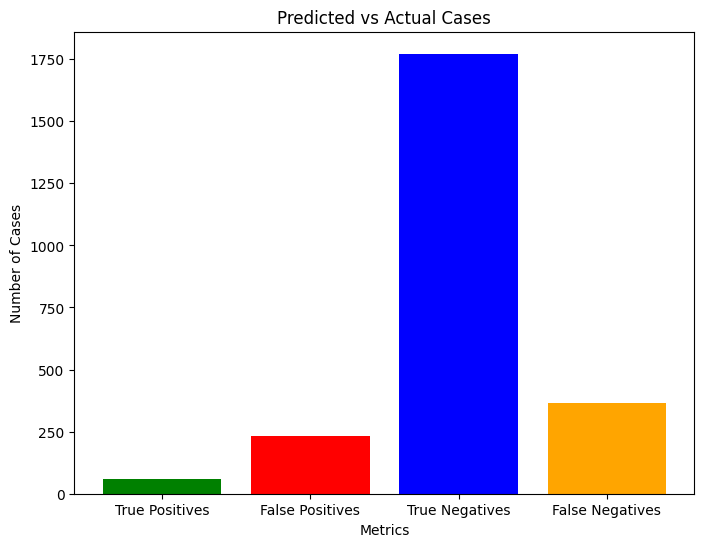

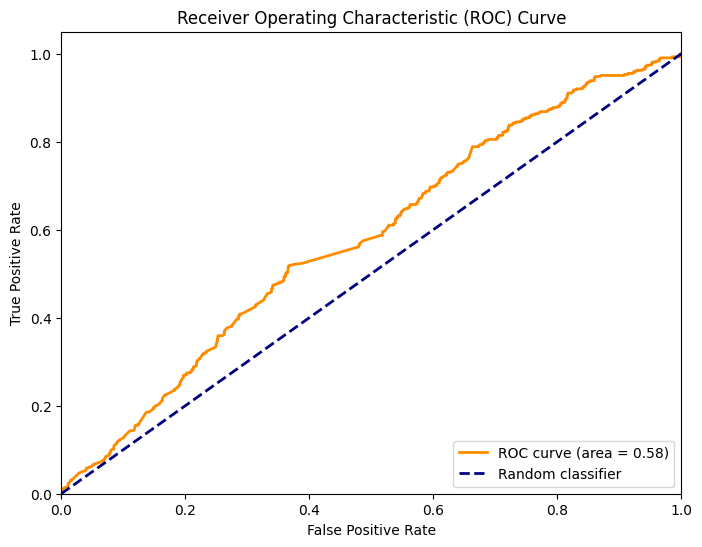

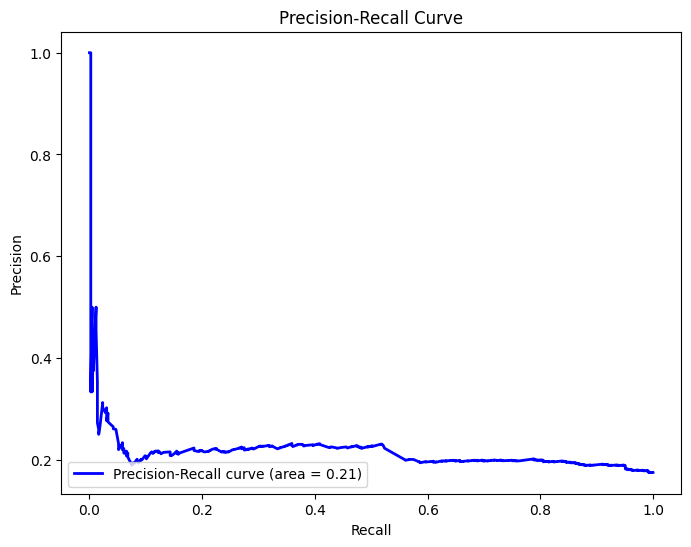

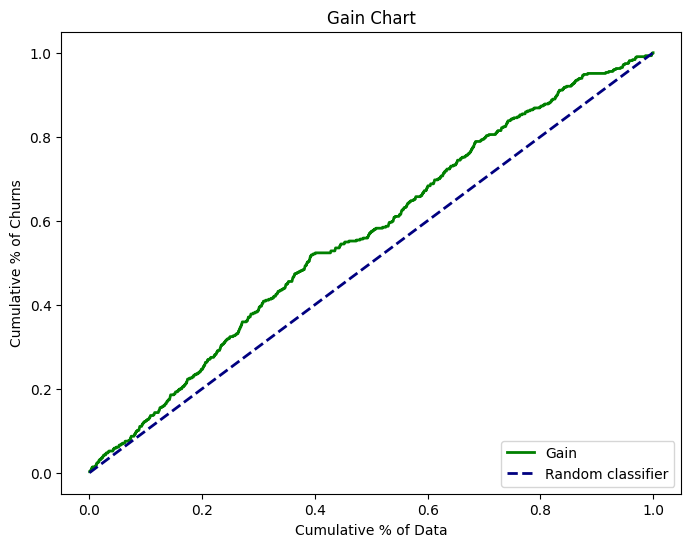

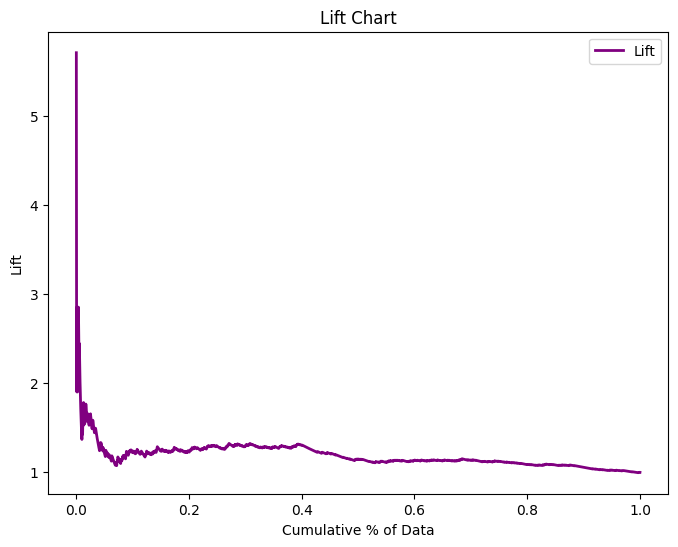


Metrics Table:
      Metric     Value
0  Precision  0.208191
1     Recall  0.143192
2    ROC AUC  0.578253
3     PR AUC  0.214691
Precision: 22.12%
Recall: 5.87%
F1 Score: 9.28%

Confusion Matrix:
True Negatives: 1916
False Positives: 88
False Negatives: 401
True Positives: 25


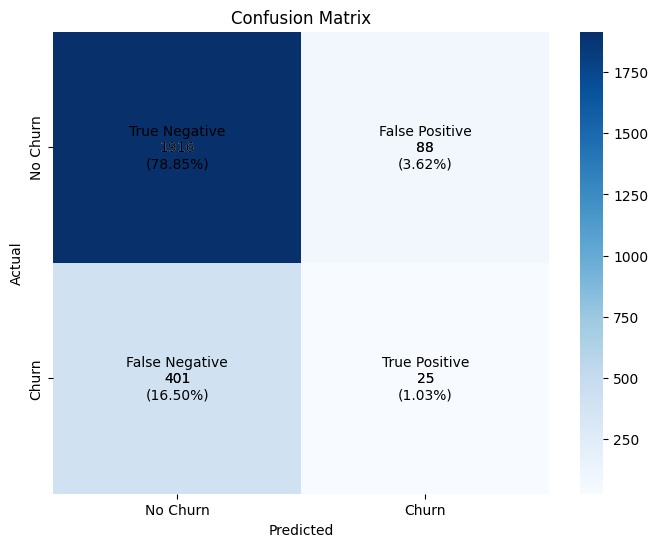

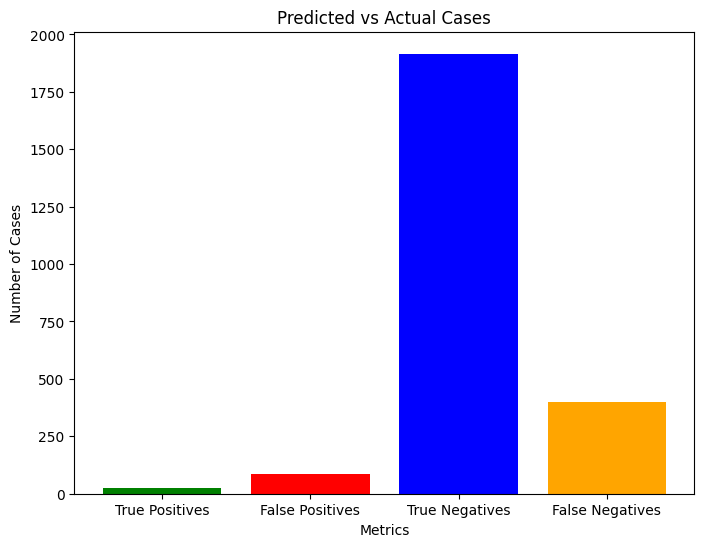

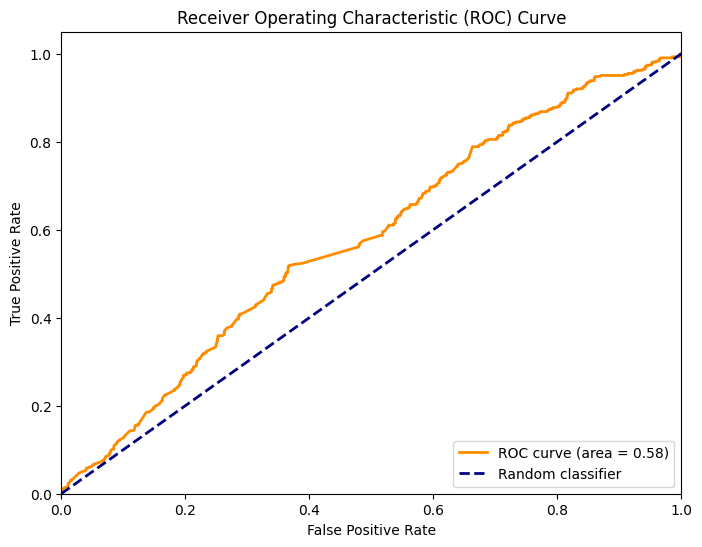

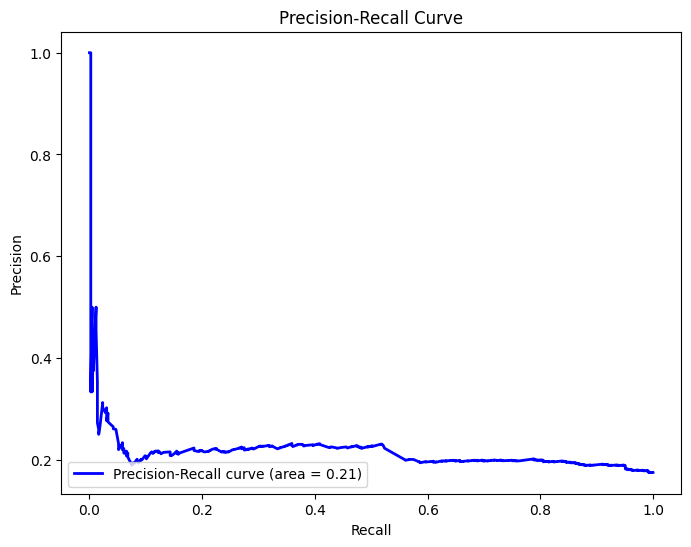

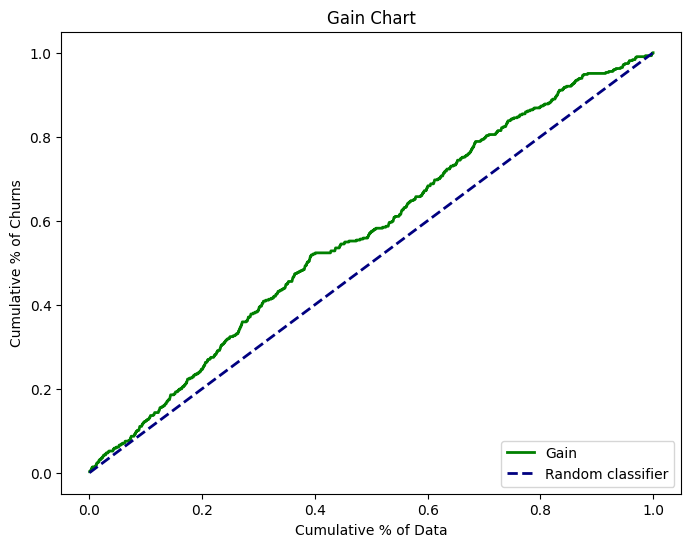

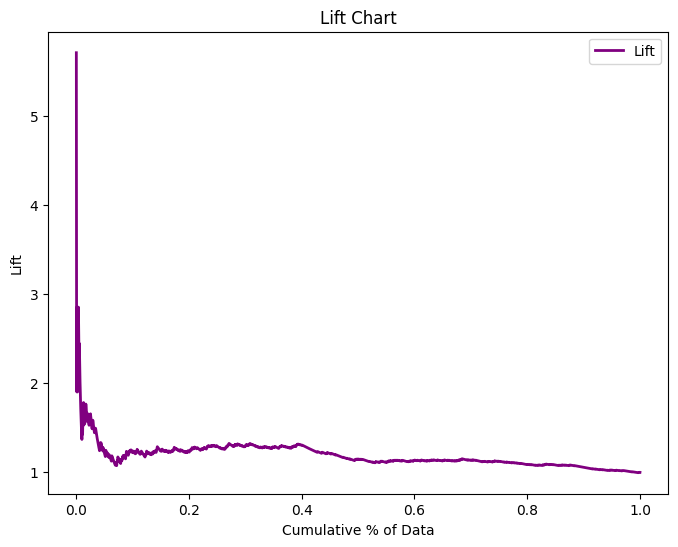


Metrics Table:
      Metric     Value
0  Precision  0.221239
1     Recall  0.058685
2    ROC AUC  0.578253
3     PR AUC  0.214691
Precision: 20.14%
Recall: 78.87%
F1 Score: 32.09%

Confusion Matrix:
True Negatives: 672
False Positives: 1332
False Negatives: 90
True Positives: 336


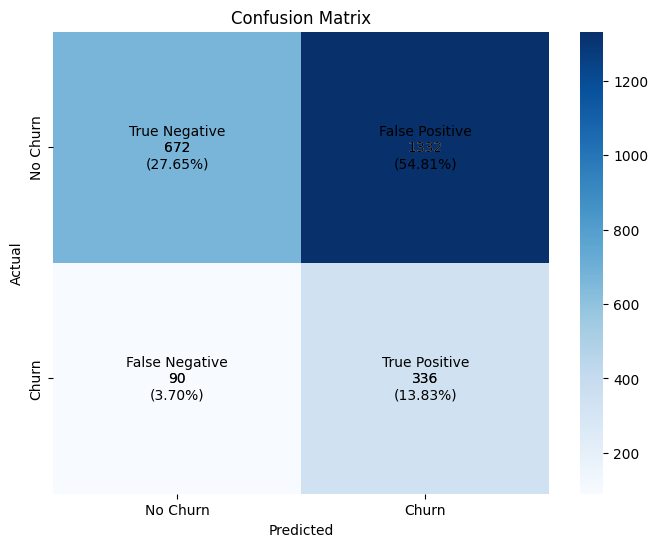

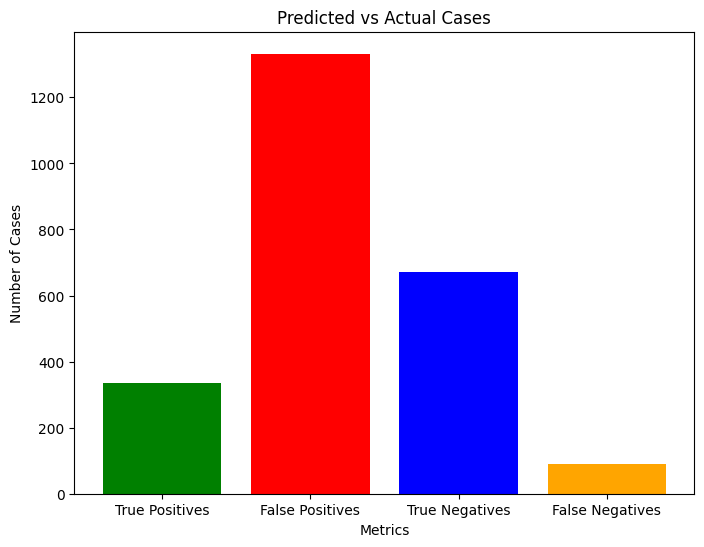

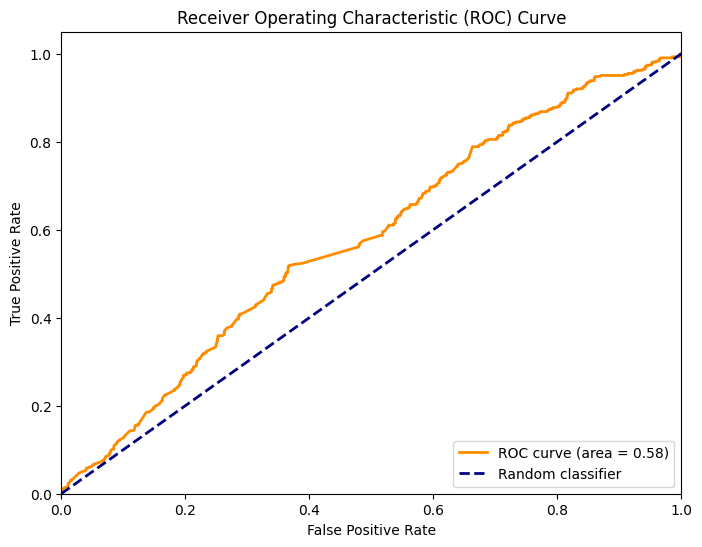

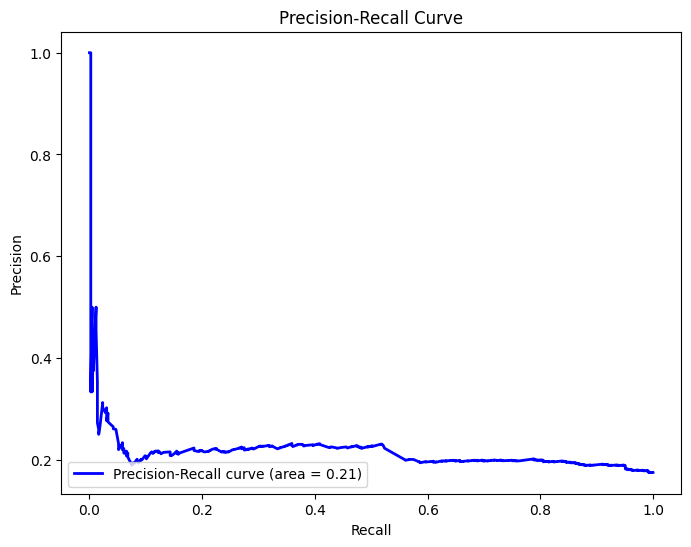

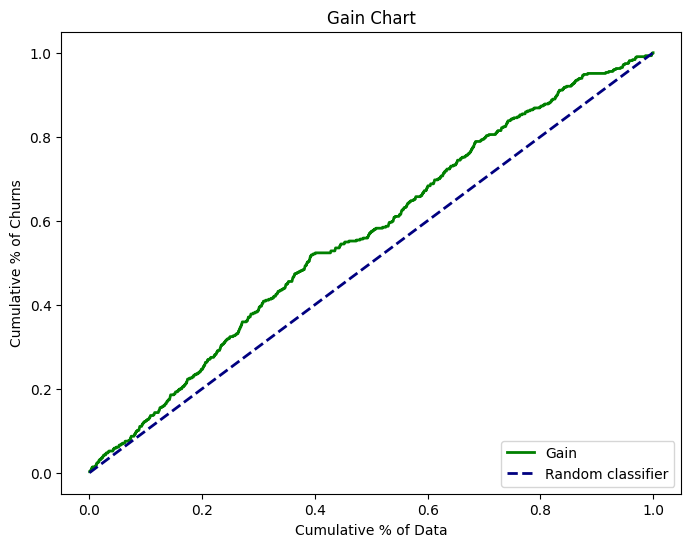

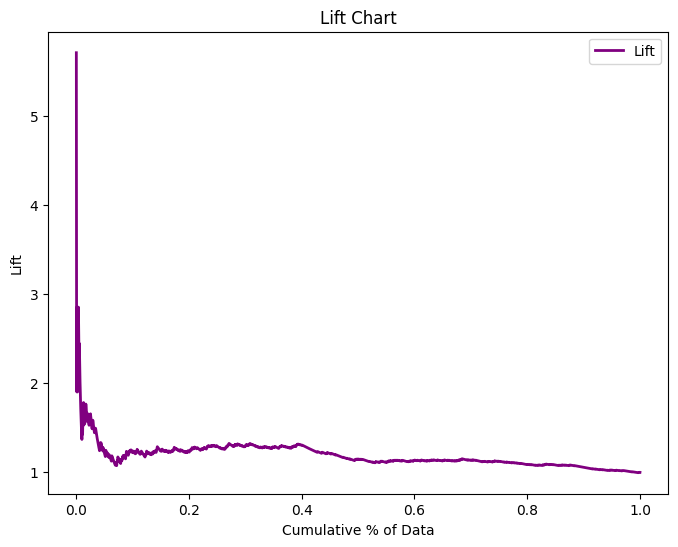


Metrics Table:
      Metric     Value
0  Precision  0.201439
1     Recall  0.788732
2    ROC AUC  0.578253
3     PR AUC  0.214691


In [20]:
confusion_chart(Churn, 0.21, 'churn_probability')
confusion_chart(Churn, 0.27, 'churn_probability')
confusion_chart(Churn, 0.083, 'churn_probability')
# confusion_chart(Churn, 0.083, 'prob_1')


## Find optimal threshold

In [86]:
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, roc_curve

def find_optimal_threshold(data, churn_probability):
    # Extract the actual labels and the predicted probabilities
    actual = data['churnflag']
    probabilities = data[churn_probability]
    
    # Calculate the ROC curve to get thresholds
    fpr, tpr, thresholds = roc_curve(actual, probabilities)
    
    # Calculate F1 scores for each threshold
    f1_scores = []
    for thresh in thresholds:
        predictions = (probabilities >= thresh).astype(int)
        score = f1_score(actual, predictions)
        f1_scores.append(score)
    
    # Find the threshold that maximized the F1 score
    max_f1_index = np.argmax(f1_scores)  # Index of the maximum F1 score
    optimal_threshold = thresholds[max_f1_index]
    max_f1_score = f1_scores[max_f1_index]
    
    print(f'Optimal Threshold: {optimal_threshold}')
    print(f'Maximum F1 Score: {max_f1_score:.4f}')
    
    # Optionally, return the optimal threshold
    return optimal_threshold, max_f1_score


# find_optimal_threshold(data, 'churn_probability')


In [87]:
find_optimal_threshold(Churn, 'churn_probability')

Optimal Threshold: 0.08385106067271551
Maximum F1 Score: 0.3159


(0.08385106067271551, 0.3158905424867979)

## Explanation of outcome

Precision: 19.72%

Precision measures the accuracy of positive predictions.
It answers the question: "Of all instances the model predicted as positive, what percentage was actually positive?"
A precision of 19.72% means that when the model predicts the positive class, it's correct only about 1 in 5 times.
This low precision indicates a high number of false positives.


Recall: 78.71%

Recall measures the model's ability to find all positive instances.
It answers the question: "Of all actual positive instances, what percentage did the model correctly identify?"
A recall of 78.71% means the model is correctly identifying about 4 out of 5 actual positive instances.
This relatively high recall suggests the model is good at catching positive cases, but at the cost of many false positives (as indicated by the low precision).


F1 Score: 31.54%

The F1 score is the harmonic mean of precision and recall, providing a single score that balances both metrics.
An F1 score of 31.54% is quite low, indicating poor overall performance in balancing precision and recall.



Interpretation:

The model has a strong bias towards predicting the positive class (high recall, low precision). It's "casting a wide net" to catch most positive cases, but in doing so, it's incorrectly labeling many negative cases as positive.
The high recall paired with low precision suggests the model might be useful for initial screening in a scenario where it's crucial not to miss positive cases, and false positives can be filtered out later through a secondary process.
The low F1 score indicates that while the model is good at finding positive cases, its overall performance is poor due to the high number of false positives.
These metrics suggest a possible imbalanced dataset or a model that's been tuned to prioritize recall over precision.

Possible next steps:

If the dataset is imbalanced, consider techniques like oversampling, undersampling, or SMOTE.
Re-evaluate the feature set and potentially engineer new features.
Try different algorithms that might be more suitable for the problem.
If appropriate for your use case, adjust the classification threshold to balance precision and recall better.
Collect more data, especially if the positive class is underrepresented.

Remember, the "best" balance between precision and recall depends on your specific use case and the costs associated with false positives versus false negatives.

In [49]:
find_optimal_threshold(Churn, 'prob_1')

Optimal Threshold: 0.7643988177843122
Maximum F1 Score: 0.2935


(0.7643988177843122, 0.29353932584269665)

Precision: 17.20%
Recall: 100.00%
F1 Score: 29.35%

Confusion Matrix:
True Negatives: 0
False Positives: 2012
False Negatives: 0
True Positives: 418


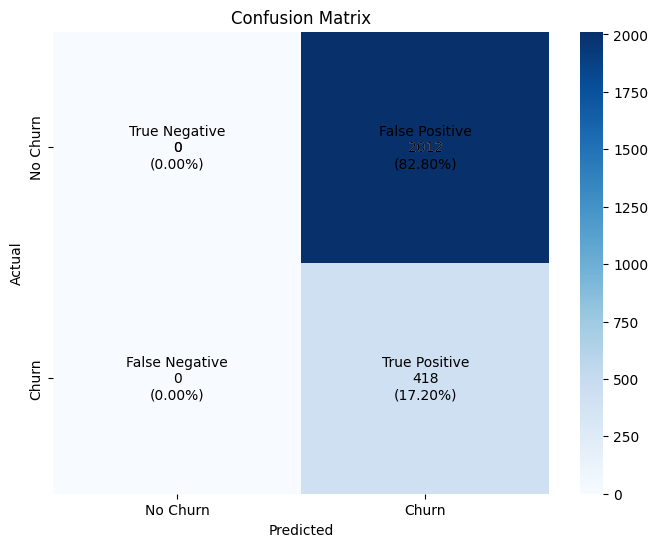

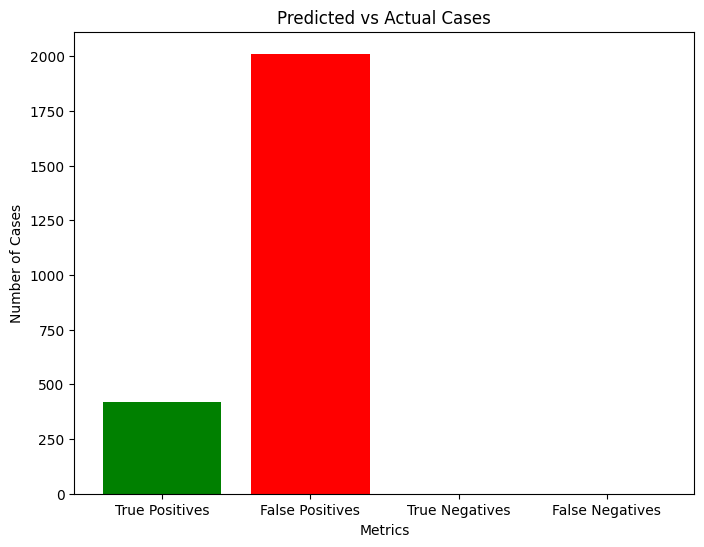

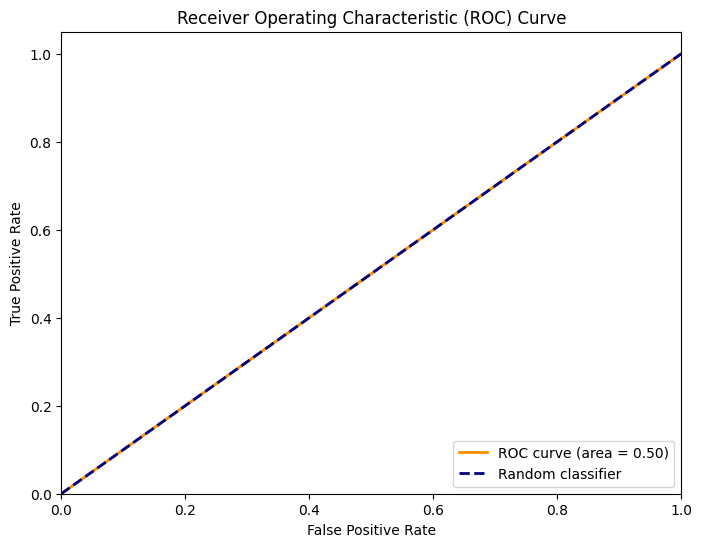

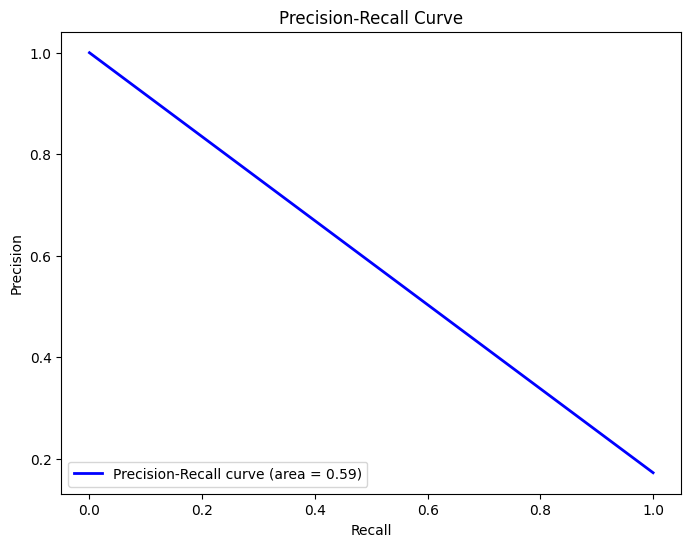

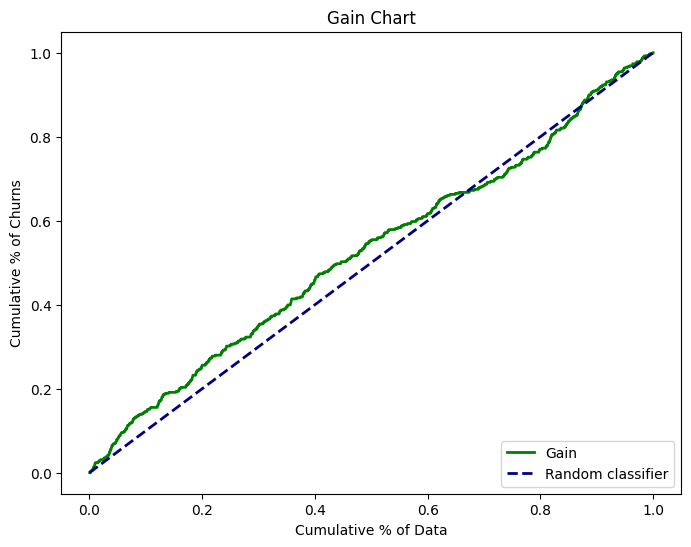

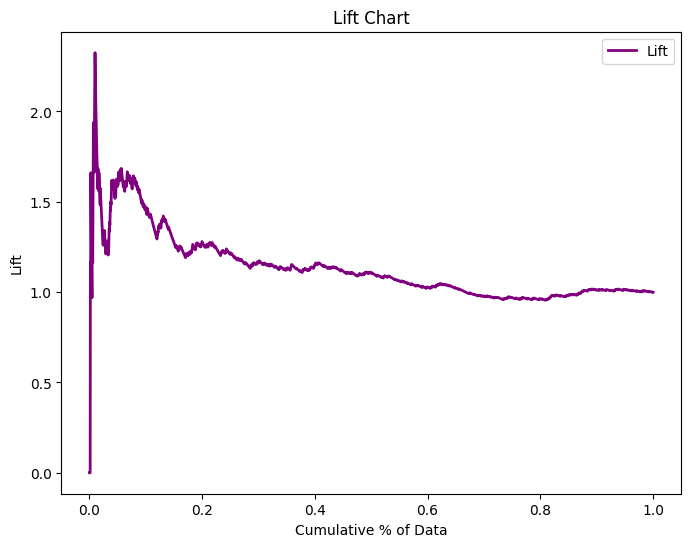


Metrics Table:
      Metric     Value
0  Precision  0.172016
1     Recall  1.000000
2    ROC AUC  0.500000
3     PR AUC  0.586008


In [50]:
Churn

Precision: 19.45%
Recall: 13.64%
F1 Score: 16.03%

Confusion Matrix:
True Negatives: 1776
False Positives: 236
False Negatives: 361
True Positives: 57


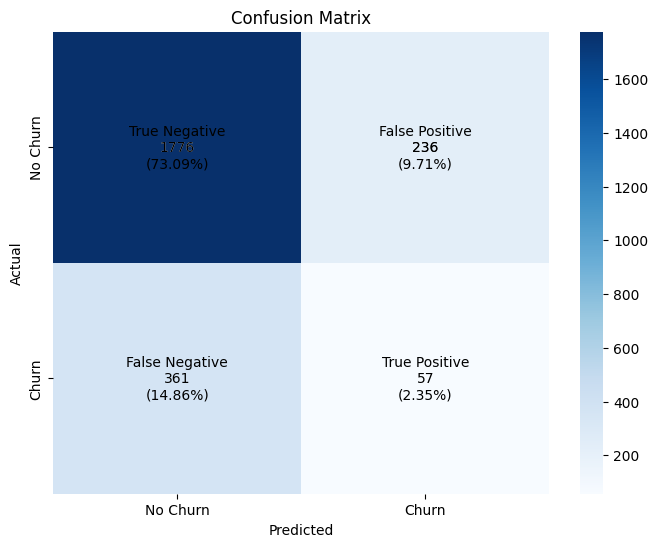

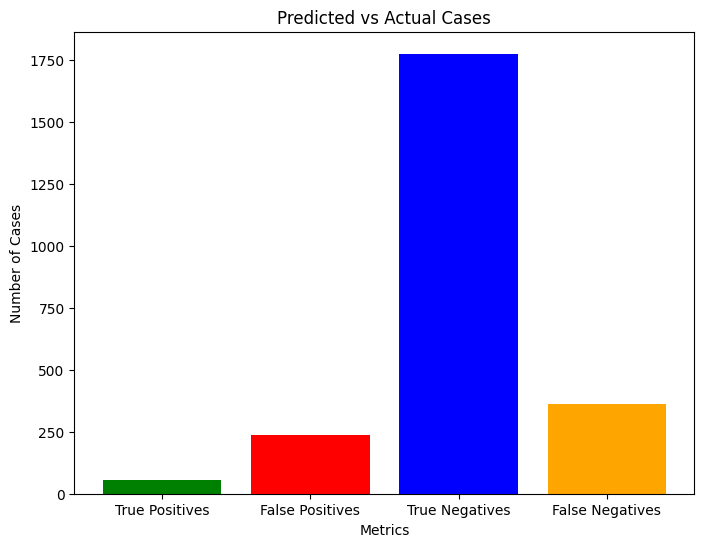

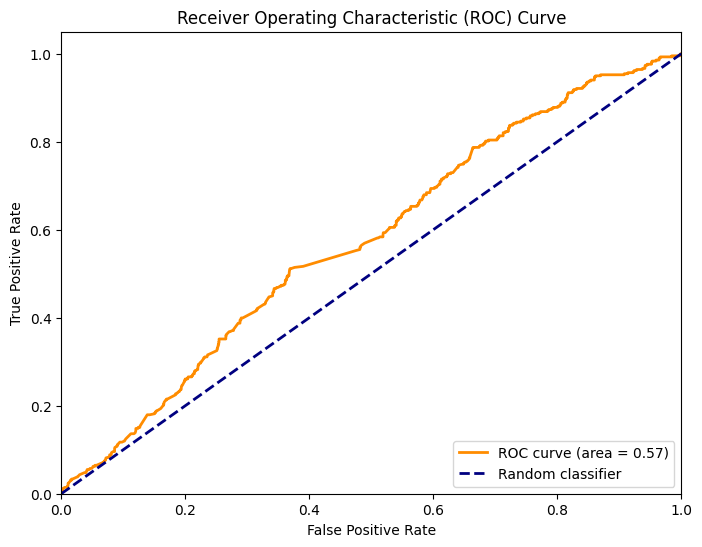

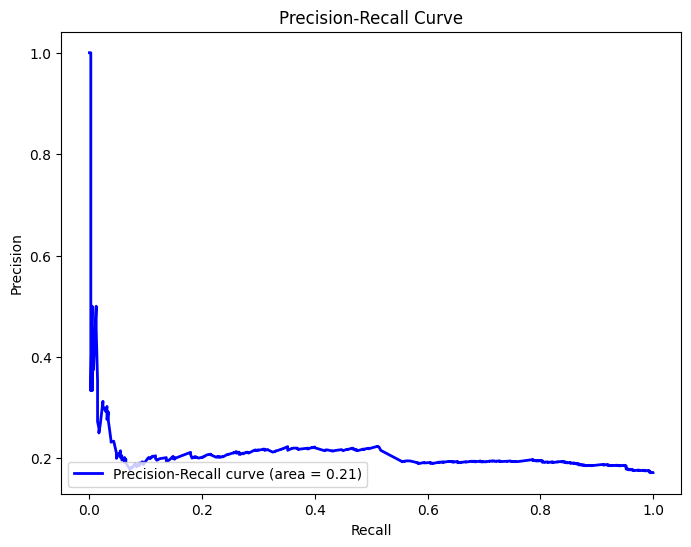

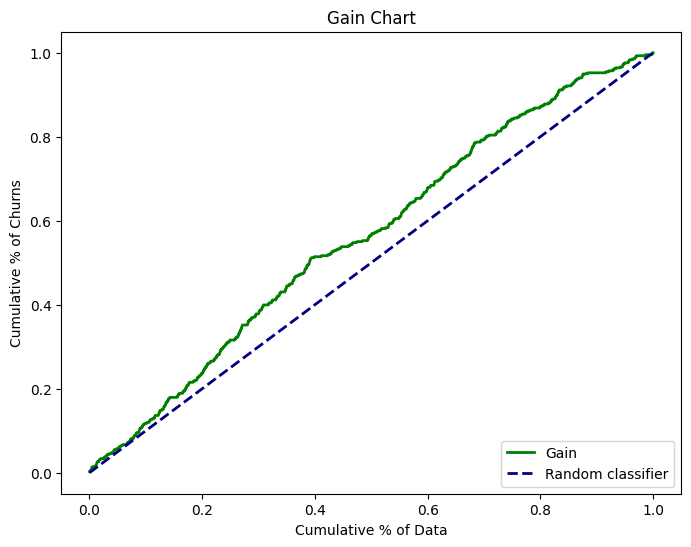

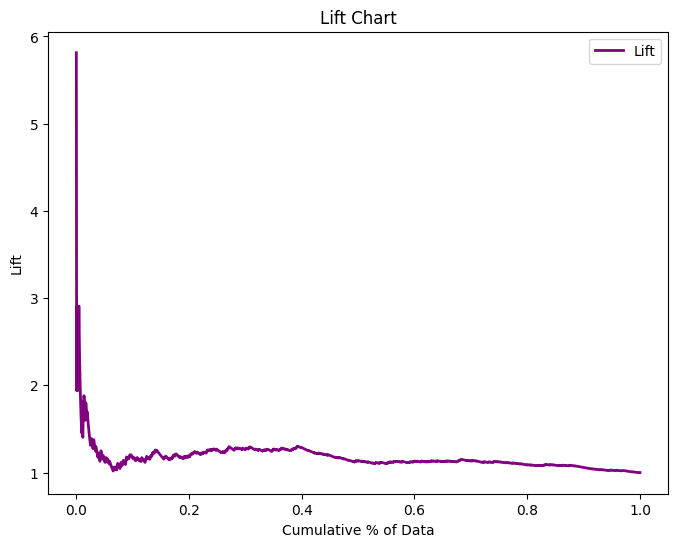


Metrics Table:
      Metric     Value
0  Precision  0.194539
1     Recall  0.136364
2    ROC AUC  0.573183
3     PR AUC  0.206890


In [52]:
confusion_chart(Churn, 0.21, 'churn_probability')

## Find a certain precision and recall as required level

In [84]:
import numpy as np
from sklearn.metrics import precision_score, recall_score

def find_required_threshold(data, churn_probability, min_precision=0.30, min_recall=0.30):
    thresholds = np.arange(0.0, 1.0, 0.01)
    optimal_threshold = None

    for threshold in thresholds:
        data['predicted_churn'] = (data[churn_probability] >= threshold).astype(int)
        
        # Skip thresholds with no positive predictions
        if data['predicted_churn'].sum() == 0:
            continue
        
        precision = precision_score(data['churnflag'], data['predicted_churn'], zero_division=0)
        recall = recall_score(data['churnflag'], data['predicted_churn'])

        if precision >= min_precision and recall >= min_recall:
            optimal_threshold = threshold
            break

    if optimal_threshold is not None:
        print(f"Optimal Threshold: {optimal_threshold}")
        print(f"Precision at Optimal Threshold: {precision:.2%}")
        print(f"Recall at Optimal Threshold: {recall:.2%}")
    else:
        print("No threshold found that meets the minimum precision and recall requirements.")

    return optimal_threshold

# optimal_threshold = find_required_threshold(data, 'churn_probability')


In [88]:
find_optimal_threshold(Jun2023, 'churn_probability')

Optimal Threshold: 0.039996336488052474
Maximum F1 Score: 0.3295


(0.039996336488052474, 0.32954545454545453)

C:\Users\DeepankarSrigyan\AppData\Local\Temp\ipykernel_3032\1353083006.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Precision: 19.95%
Recall: 89.69%
F1 Score: 32.65%

Confusion Matrix:
True Negatives: 90
False Positives: 349
False Negatives: 10
True Positives: 87


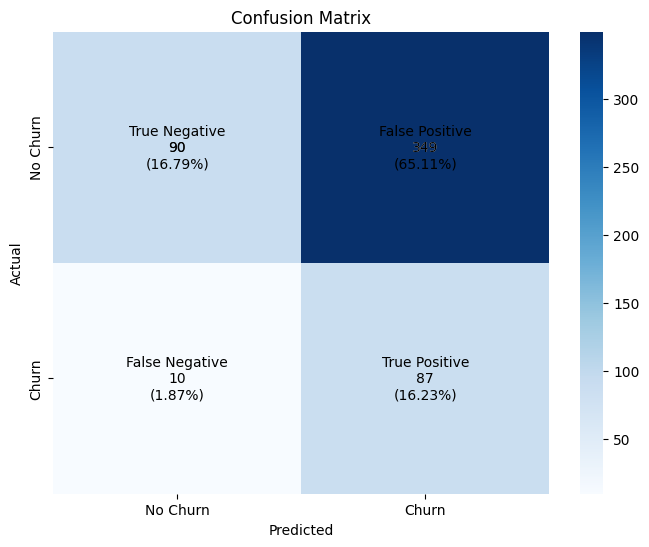

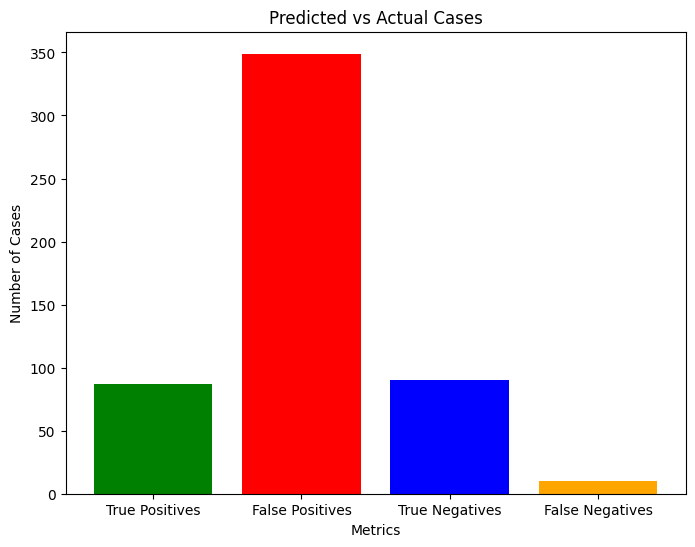

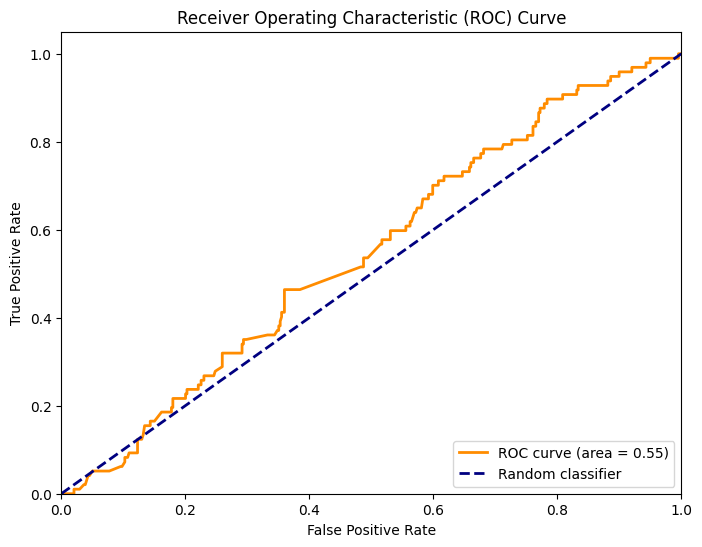

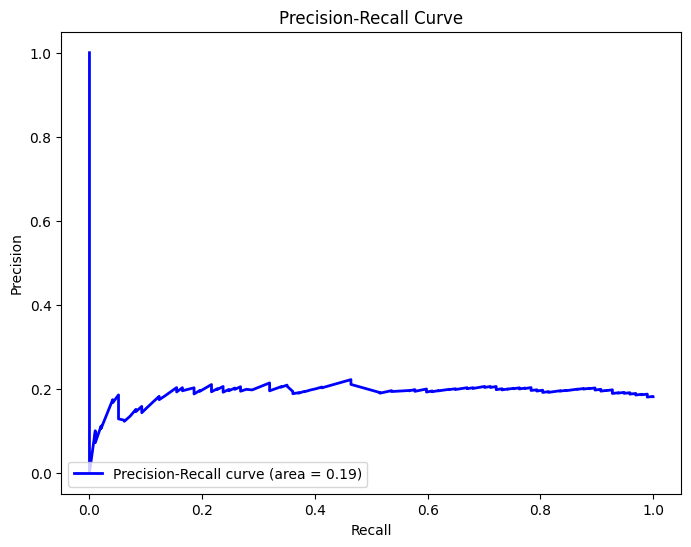

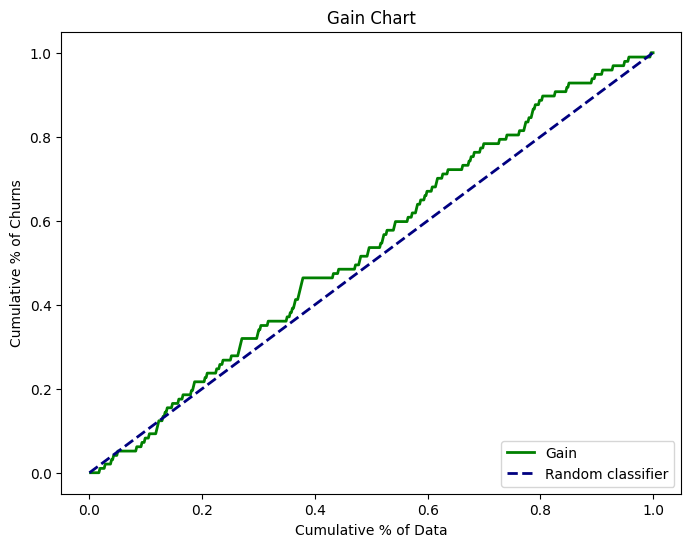

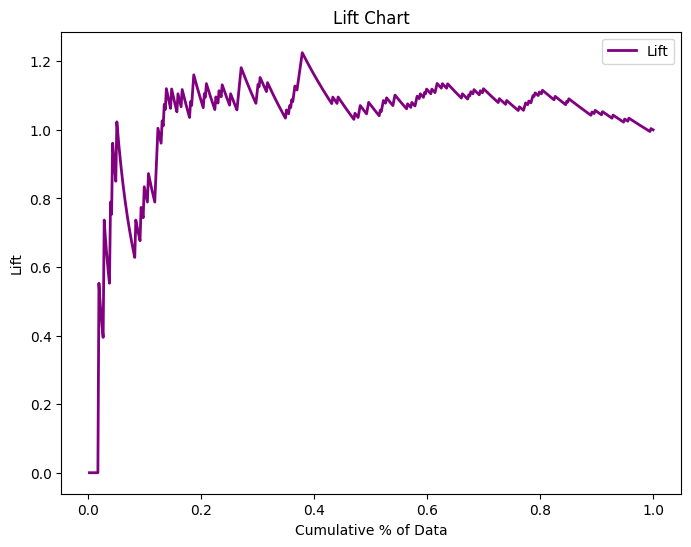


Metrics Table:
      Metric     Value
0  Precision  0.199541
1     Recall  0.896907
2    ROC AUC  0.546544
3     PR AUC  0.190229


In [89]:
confusion_chart(Jun2023, 0.039, 'churn_probability')

In [90]:
Jul2023 = Churn[(Churn['PropertyLiveDate'] >= '2023-07-01') & (Churn['PropertyLiveDate'] < '2023-08-01')]
Jul2023

,PropertyID,PropertyReference,PropertyLiveDate,DateToldWithdrawingLocal,churned_month,current_month,churnflag,churn_probability,prob_1,prob_2,prob_3,prob_4,predicted_churn
4,53802,15299,2023-07-03,None,NaN,12,0,0.118841,0.764399,0.456545,0.86247,0.833357,0
5,55233,22474,2023-07-05,None,NaN,12,0,0.065420,0.764399,0.456545,0.86247,0.833357,0
13,87290,955518,2023-07-07,None,NaN,12,0,0.123262,0.764399,0.456545,0.86247,0.833357,0
14,90268,957116,2023-07-13,None,NaN,12,0,0.094816,0.764399,0.456545,0.86247,0.833357,0
33,119956,1013302,2023-07-19,None,NaN,12,0,0.234311,0.764399,0.456545,0.86247,0.833357,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1844,236704,1139830,2023-07-28,2024-03-06,9.0,12,1,0.167494,0.764399,0.456545,0.86247,0.833357,0
1845,236707,1139792,2023-07-28,None,NaN,12,0,0.325307,0.764399,0.456545,0.86247,0.833357,0
1867,236874,1140060,2023-07-31,None,NaN,12,0,0.194419,0.764399,0.456545,0.86247,0.833357,0
1890,237130,1140186,2023-07-27,None,NaN,12,0,0.125106,0.764399,0.456545,0.86247,0.833357,0


In [91]:
find_optimal_threshold(Jul2023, 'churn_probability')

Optimal Threshold: 0.14771620772180907
Maximum F1 Score: 0.4014


(0.14771620772180907, 0.4014084507042254)

C:\Users\DeepankarSrigyan\AppData\Local\Temp\ipykernel_3032\1353083006.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Precision: 30.64%
Recall: 50.96%
F1 Score: 38.27%

Confusion Matrix:
True Negatives: 255
False Positives: 120
False Negatives: 51
True Positives: 53


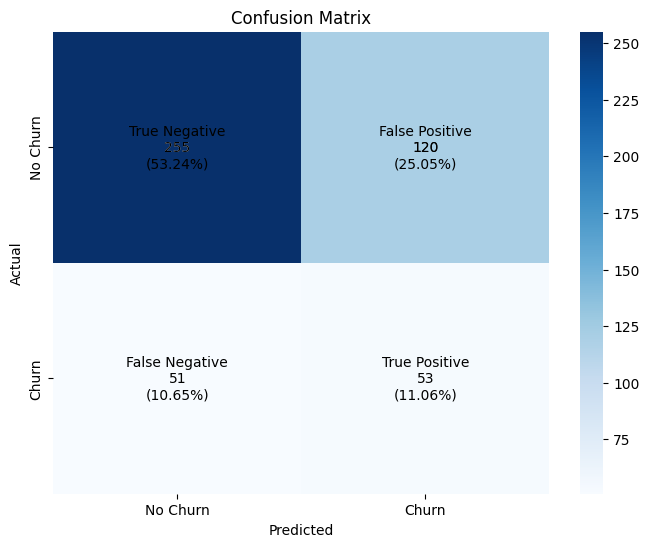

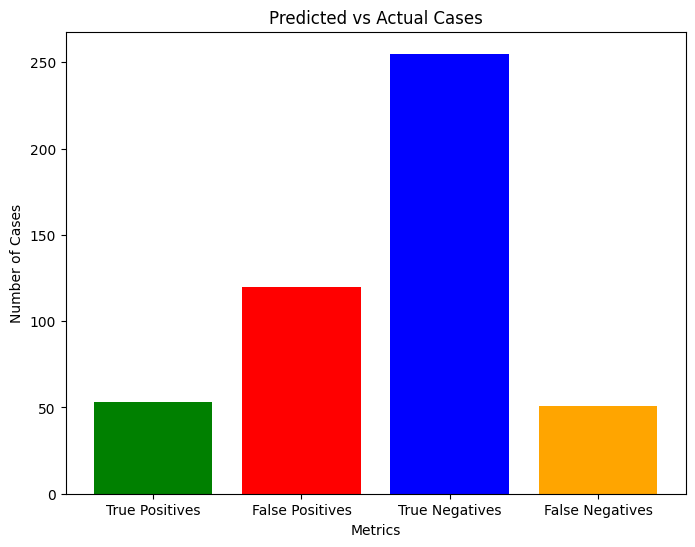

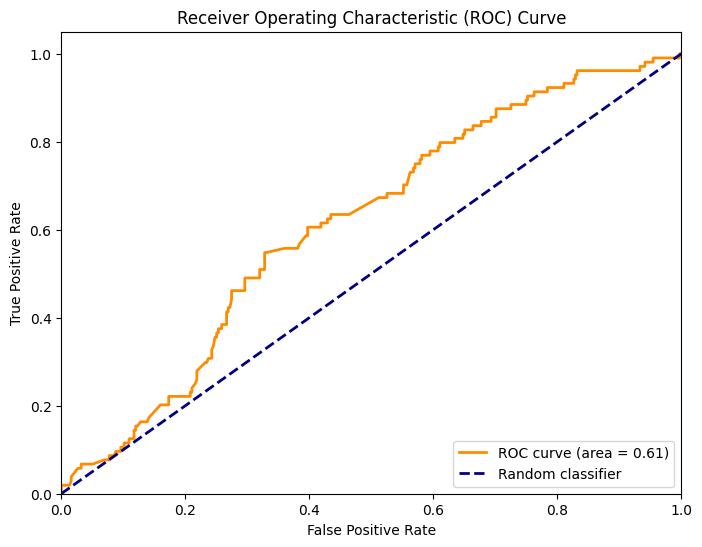

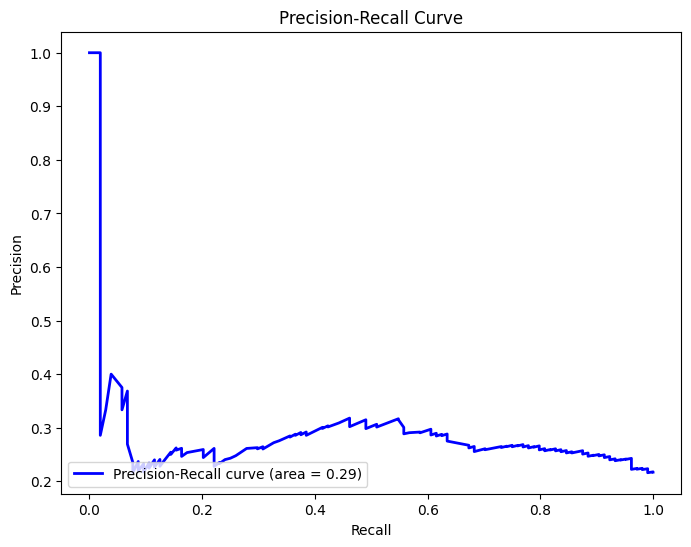

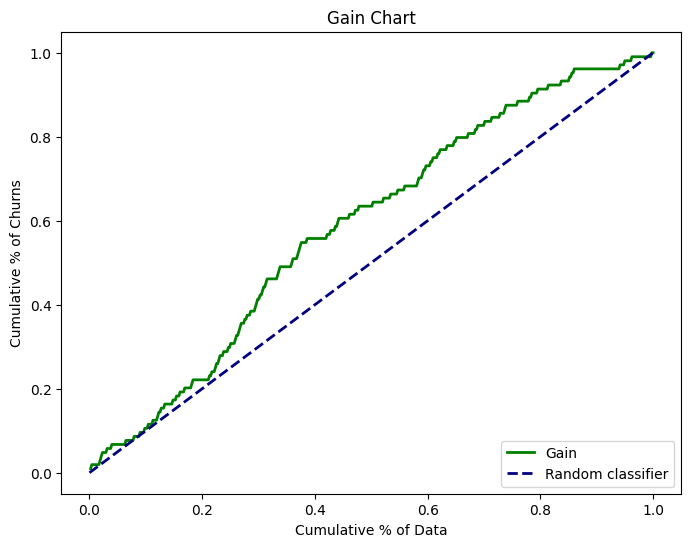

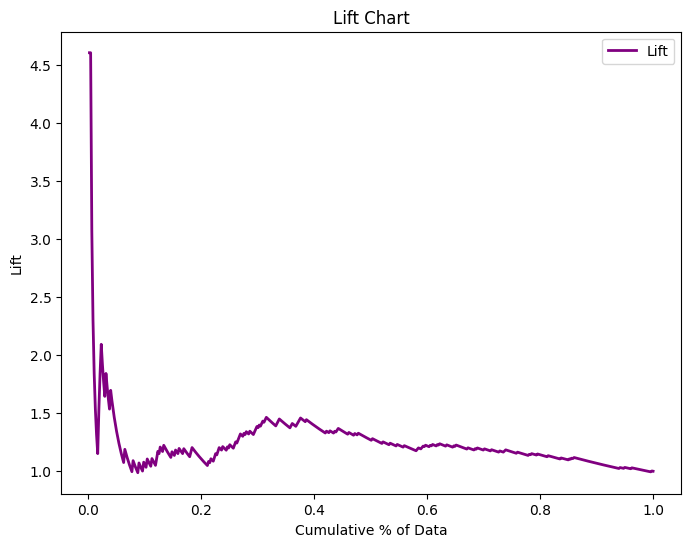


Metrics Table:
      Metric     Value
0  Precision  0.306358
1     Recall  0.509615
2    ROC AUC  0.613026
3     PR AUC  0.285229


In [96]:
confusion_chart(Jul2023, 0.15, 'churn_probability')

In [21]:
# find_required_threshold(Jul2023, 'churn_probability', min_precision=0.30, min_recall=0.30)

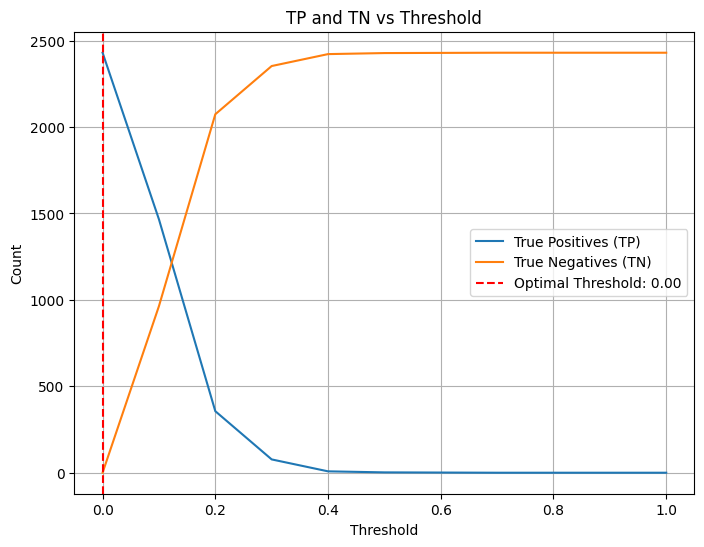

Optimal Threshold: 0.00
Max TP: 2430
Max TN: 0


In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def find_optimal_threshold(dataset, prob_column):
    # Sort dataset by probability column in descending order
    dataset = dataset.sort_values(by=prob_column, ascending=False).reset_index(drop=True)
    
    # Extract predicted probabilities
    predicted_probs = dataset[prob_column]
    
    # Initialize lists to store TP, TN, thresholds
    tp_list = []
    tn_list = []
    thresholds = []
    
    # Iterate through thresholds from 0 to 1 (or adapt based on your probabilities range)
    for threshold in np.arange(0, 1.1, 0.1):
        predicted_labels = (predicted_probs >= threshold).astype(int)
        
        # Calculate confusion matrix components
        tp = np.sum(predicted_labels == 1)
        tn = np.sum(predicted_labels == 0)
        
        # Append values to lists
        tp_list.append(tp)
        tn_list.append(tn)
        thresholds.append(threshold)
    
    # Find the optimal threshold that maximizes both TP and TN
    optimal_idx = np.argmax(np.array(tp_list) + np.array(tn_list))
    optimal_threshold = thresholds[optimal_idx]
    max_tp = tp_list[optimal_idx]
    max_tn = tn_list[optimal_idx]
    
    # Plot TP and TN vs Threshold (optional)
    plt.figure(figsize=(8, 6))
    plt.plot(thresholds, tp_list, label='True Positives (TP)')
    plt.plot(thresholds, tn_list, label='True Negatives (TN)')
    plt.axvline(x=optimal_threshold, color='r', linestyle='--', label=f'Optimal Threshold: {optimal_threshold:.2f}')
    plt.xlabel('Threshold')
    plt.ylabel('Count')
    plt.title('TP and TN vs Threshold')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return optimal_threshold, max_tp, max_tn

# Example usage:
# Assuming 'dataset' is your pandas DataFrame with a column containing predicted probabilities
# Replace 'probability_column' with the actual column name containing predicted probabilities
optimal_threshold, max_tp, max_tn = find_optimal_threshold(Churn, 'churn_probability')
print(f'Optimal Threshold: {optimal_threshold:.2f}')
print(f'Max TP: {max_tp}')
print(f'Max TN: {max_tn}')
